In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats                      
from iminuit import Minuit
from iminuit.cost import LeastSquares
from itertools import accumulate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd

In [2]:
t_HLA = np.load('times_HLA.npy')
t_DAZ = np.load('times_DAZ.npy')
t_LWN = np.load('times_LWN.npy')
t_PVX = np.load('times_PVX.npy')

t1 = t_HLA
t2 = (t_DAZ[:-1] + t_DAZ[1:])[::2]
t3 = (t_LWN[:-2] + t_LWN[1:-1] + t_LWN[2:])[::3]
t4 = (t_PVX[:-2] + t_PVX[1:-1] + t_PVX[2:])[::3]

t1_sum = np.cumsum(t1)
t2_sum = np.cumsum(t2)
t3_sum = np.cumsum(t3)
t4_sum = np.cumsum(t4)

t1_mean = np.mean(t1)
t2_mean = np.mean(t2)
t3_mean = np.mean(t3)
t4_mean = np.mean(t4)

t1_std = np.std(t1)
t2_std = np.std(t2)
t3_std = np.std(t3)
t4_std = np.std(t4)

min_valuse = min(len(t1), len(t2), len(t3), len(t4))

all_times = np.zeros((4, min_valuse))
all_times[0, :] = t1[:min_valuse]
all_times[1, :] = t2[:min_valuse]
all_times[2, :] = t3[:min_valuse]
all_times[3, :] = t4[:min_valuse]
times = np.mean(all_times, axis=0)

times_sum = np.cumsum(times)


In [3]:
save_plots = False
Minuit.print_level = 0

#Uncertaintees
a = 9.82
b = 0
sigmay = np.std(t2)

x = np.arange(len(t2_sum))+1
y = np.array(t2_sum) 
sy = sigmay*np.ones_like(x)

def fit_func(x, a, b): 
    return a*x + b

chi2 = LeastSquares(x,y,sy,fit_func)

def chi2_func(a,b):
    return np.sum(((y - fit_func(x,a,b)) / sy)**2)

mfit = Minuit(chi2_func,a=a,b=b)

mfit.migrad();

a_fit = mfit.values['a']
b_fit = mfit.values['b']
sigma_a_fit = mfit.errors['a']
sigma_b_fit = mfit.errors['b']

Nvar = 2                     
Ndof_fit = len(t2) - Nvar

Chi2_fit = mfit.fval                            
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)



print(f"  Fit: a={a_fit:6.3f}+-{sigma_a_fit:5.3f}  b={b_fit:5.3f}+-{sigma_b_fit:5.3f}  p={Prob_fit:6.4f}")



  Fit: a= 9.397+-0.001  b=-0.033+-0.029  p=0.8317


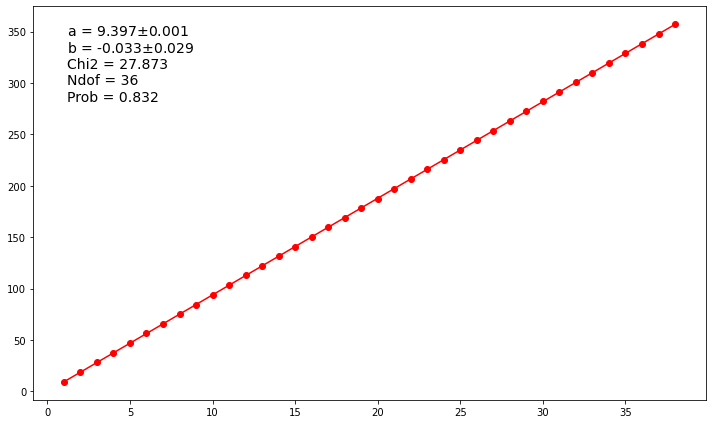

In [4]:
fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(x, y, sy, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
ax.plot(x, fit_func(x, *mfit.values[:]), '-r')

fit_info = [f'a = {a_fit:5.3f}' + r'$\pm$' +  f"{sigma_a_fit:5.3f}",
            f'b = {b_fit:5.3f}' + r'$\pm$' + f"{sigma_b_fit:5.3f}",
            f'Chi2 = {Chi2_fit:5.3f}',
            f'Ndof = {Ndof_fit:d}',
            f'Prob = {Prob_fit:5.3f}',
]
ax.text(0.05, 0.76, "\n".join(fit_info), fontsize=14, transform = ax.transAxes)
fig.tight_layout()


[-4.63895421 -4.71475606 -4.63936762 -4.48179798 -4.73459868 -4.6699429
 -4.59813885 -4.60415988 -4.69992976 -4.65589504 -4.64298563 -4.70109515
 -4.55010585 -4.69749407 -4.52821498 -4.69129185 -4.65738492 -4.54121499
 -4.73213367 -4.44740991 -4.7264028  -4.80991988 -4.6687818  -4.67699198
 -4.59803395 -4.51055817 -4.79604892 -4.64742188 -4.62369423 -4.84408192
 -4.48295121 -4.57658391 -4.6938961  -4.55137376 -4.69721989 -4.68447404
 -4.62336378 -4.61927395]


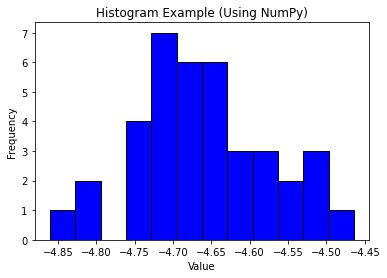

In [14]:
t2np = np.array(t2)
residuals = a_fit - t2np

print(residuals)

counts, bin_edges = np.histogram(residuals, bins=12)

# Plot the histogram
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), color='blue', edgecolor='black')

# Add titles and labels
plt.title('Histogram Example (Using NumPy)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

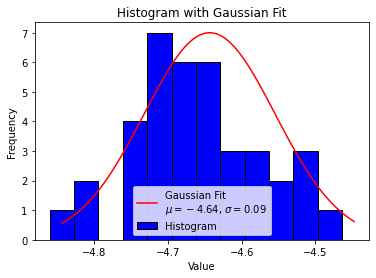

Fitted standard deviation (sigma): 0.09


In [15]:
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1]) 

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

least_squares = LeastSquares(bin_centers, counts, np.sqrt(counts), gaussian)


m = Minuit(least_squares, A=max(counts), mu=np.mean(residuals), sigma=np.std(residuals))
m.migrad()  

A_fit, mu_fit, sigma_fit = m.values["A"], m.values["mu"], m.values["sigma"]

x_fit = np.linspace(bin_edges[0], bin_edges[-1], 500)
y_fit = gaussian(x_fit, A_fit, mu_fit, sigma_fit)

plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), color='blue', edgecolor='black', label="Histogram")
plt.plot(x_fit, y_fit, color="red", label=f"Gaussian Fit\n$\mu={mu_fit:.2f}$, $\sigma={sigma_fit:.2f}$")
plt.title("Histogram with Gaussian Fit")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Fitted standard deviation (sigma): {sigma_fit:.2f}")


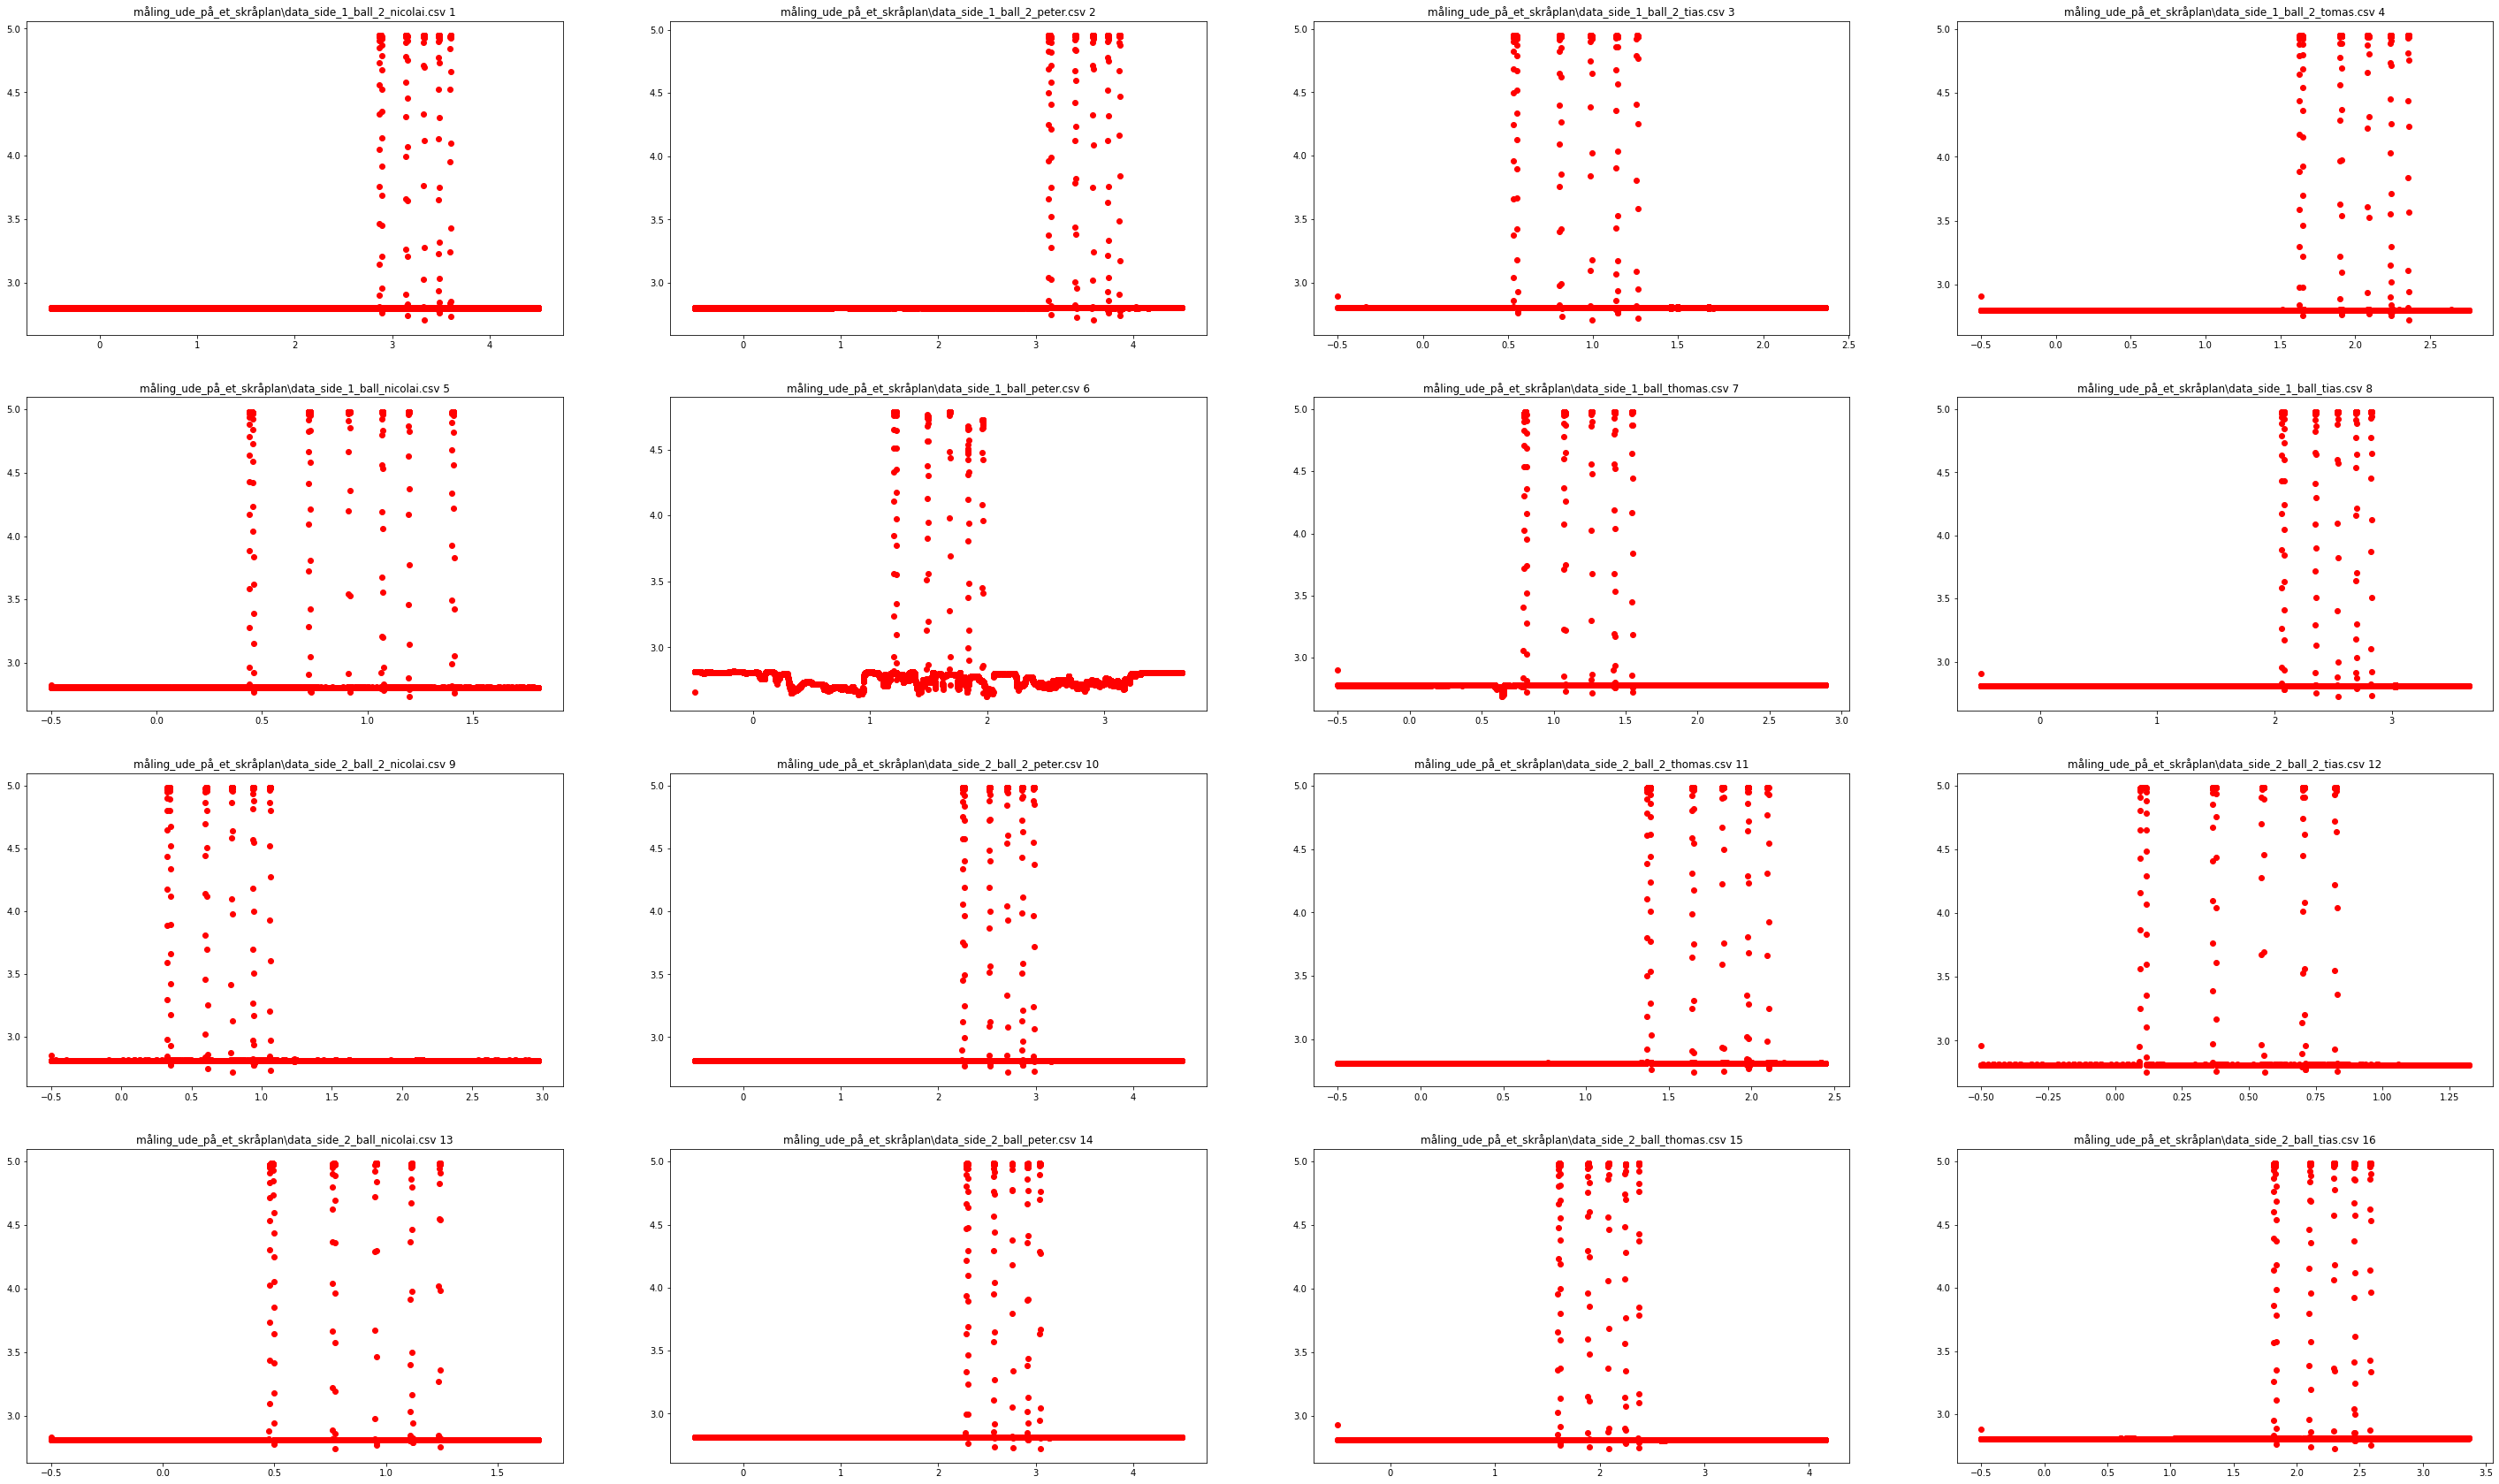

In [6]:
import glob as gb

files = gb.glob('måling_ude_på_et_skråplan/*.csv')


data_points  = []
for i, file in enumerate(files):
   data_points.append(np.genfromtxt(file, delimiter=',', skip_header=15, usecols=(0,1)))
   


fig, axs = plt.subplots(4,4,figsize=(50,30))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(data_points[i][:,0], data_points[i][:,1], 'ro')
    ax.set_title(f'{files[i]} {i+1}')


In [7]:
sensor_afstand_1 = np.array([18.6,36.4,54.5,73.6,91.2]) / 100
sensor_afstand_2 = np.array([18.7,36.3,54.6,73.5,91.2]) / 100
sensor_afstand_3 = np.array([18.7,36.4,54.6,73.55,91.65]) / 100
sensor_afstand_4 = np.array([18.4,36.4,54.5,73.5,91.2]) / 100
samlet_afstand = (sensor_afstand_1 + sensor_afstand_2 + sensor_afstand_3 + sensor_afstand_4) / 4 

d_r_inder = 0.006 
bold_1 = 0.01

vinkel_v = (76.1 + 76.5 + 76.1 + 76.2) / 4
vinkel_h = (76 + 76.3 + 75.95 + 75.9) / 4 
vinkel_v1 = (76.4 + 76.5 + 76.2 + 76.3) / 4
vinkel_h1 = (75.9 + 76.5 + 76 + 76) / 4
samlet_vinkel = (vinkel_v + vinkel_h + vinkel_v1 + vinkel_h1) / 4



fit: a= 5.286+-1.646  b=-0.464+-1.263  c=0.210+-0.206  p=0.8664
fit: a= 5.307+-1.657  b=-0.451+-1.266  c=0.210+-0.206  p=0.8688
fit: a= 5.302+-1.654  b=-0.454+-1.266  c=0.210+-0.206  p=0.8675
fit: a= 5.295+-1.651  b=-0.457+-1.265  c=0.210+-0.206  p=0.8661
fit: a= 4.871+-1.523  b=-0.397+-1.206  c=0.208+-0.204  p=0.8741
fit: a= 4.864+-1.515  b=-0.413+-1.203  c=0.208+-0.204  p=0.8708
fit: a= 4.857+-1.525  b=-0.379+-1.207  c=0.208+-0.204  p=0.8780
fit: a= 4.820+-1.508  b=-0.393+-1.200  c=0.208+-0.204  p=0.8756
fit: a= 5.217+-1.622  b=-0.464+-1.253  c=0.210+-0.206  p=0.8666
fit: a= 5.211+-1.627  b=-0.450+-1.255  c=0.210+-0.206  p=0.8664
fit: a= 5.256+-1.640  b=-0.451+-1.260  c=0.210+-0.206  p=0.8680
fit: a= 5.256+-1.642  b=-0.448+-1.261  c=0.210+-0.206  p=0.8659
fit: a= 4.816+-1.504  b=-0.401+-1.199  c=0.208+-0.204  p=0.8729
fit: a= 4.837+-1.513  b=-0.395+-1.202  c=0.208+-0.204  p=0.8748
fit: a= 4.695+-1.469  b=-0.397+-1.185  c=0.209+-0.204  p=0.8630
fit: a= 4.752+-1.483  b=-0.400+-1.190  c

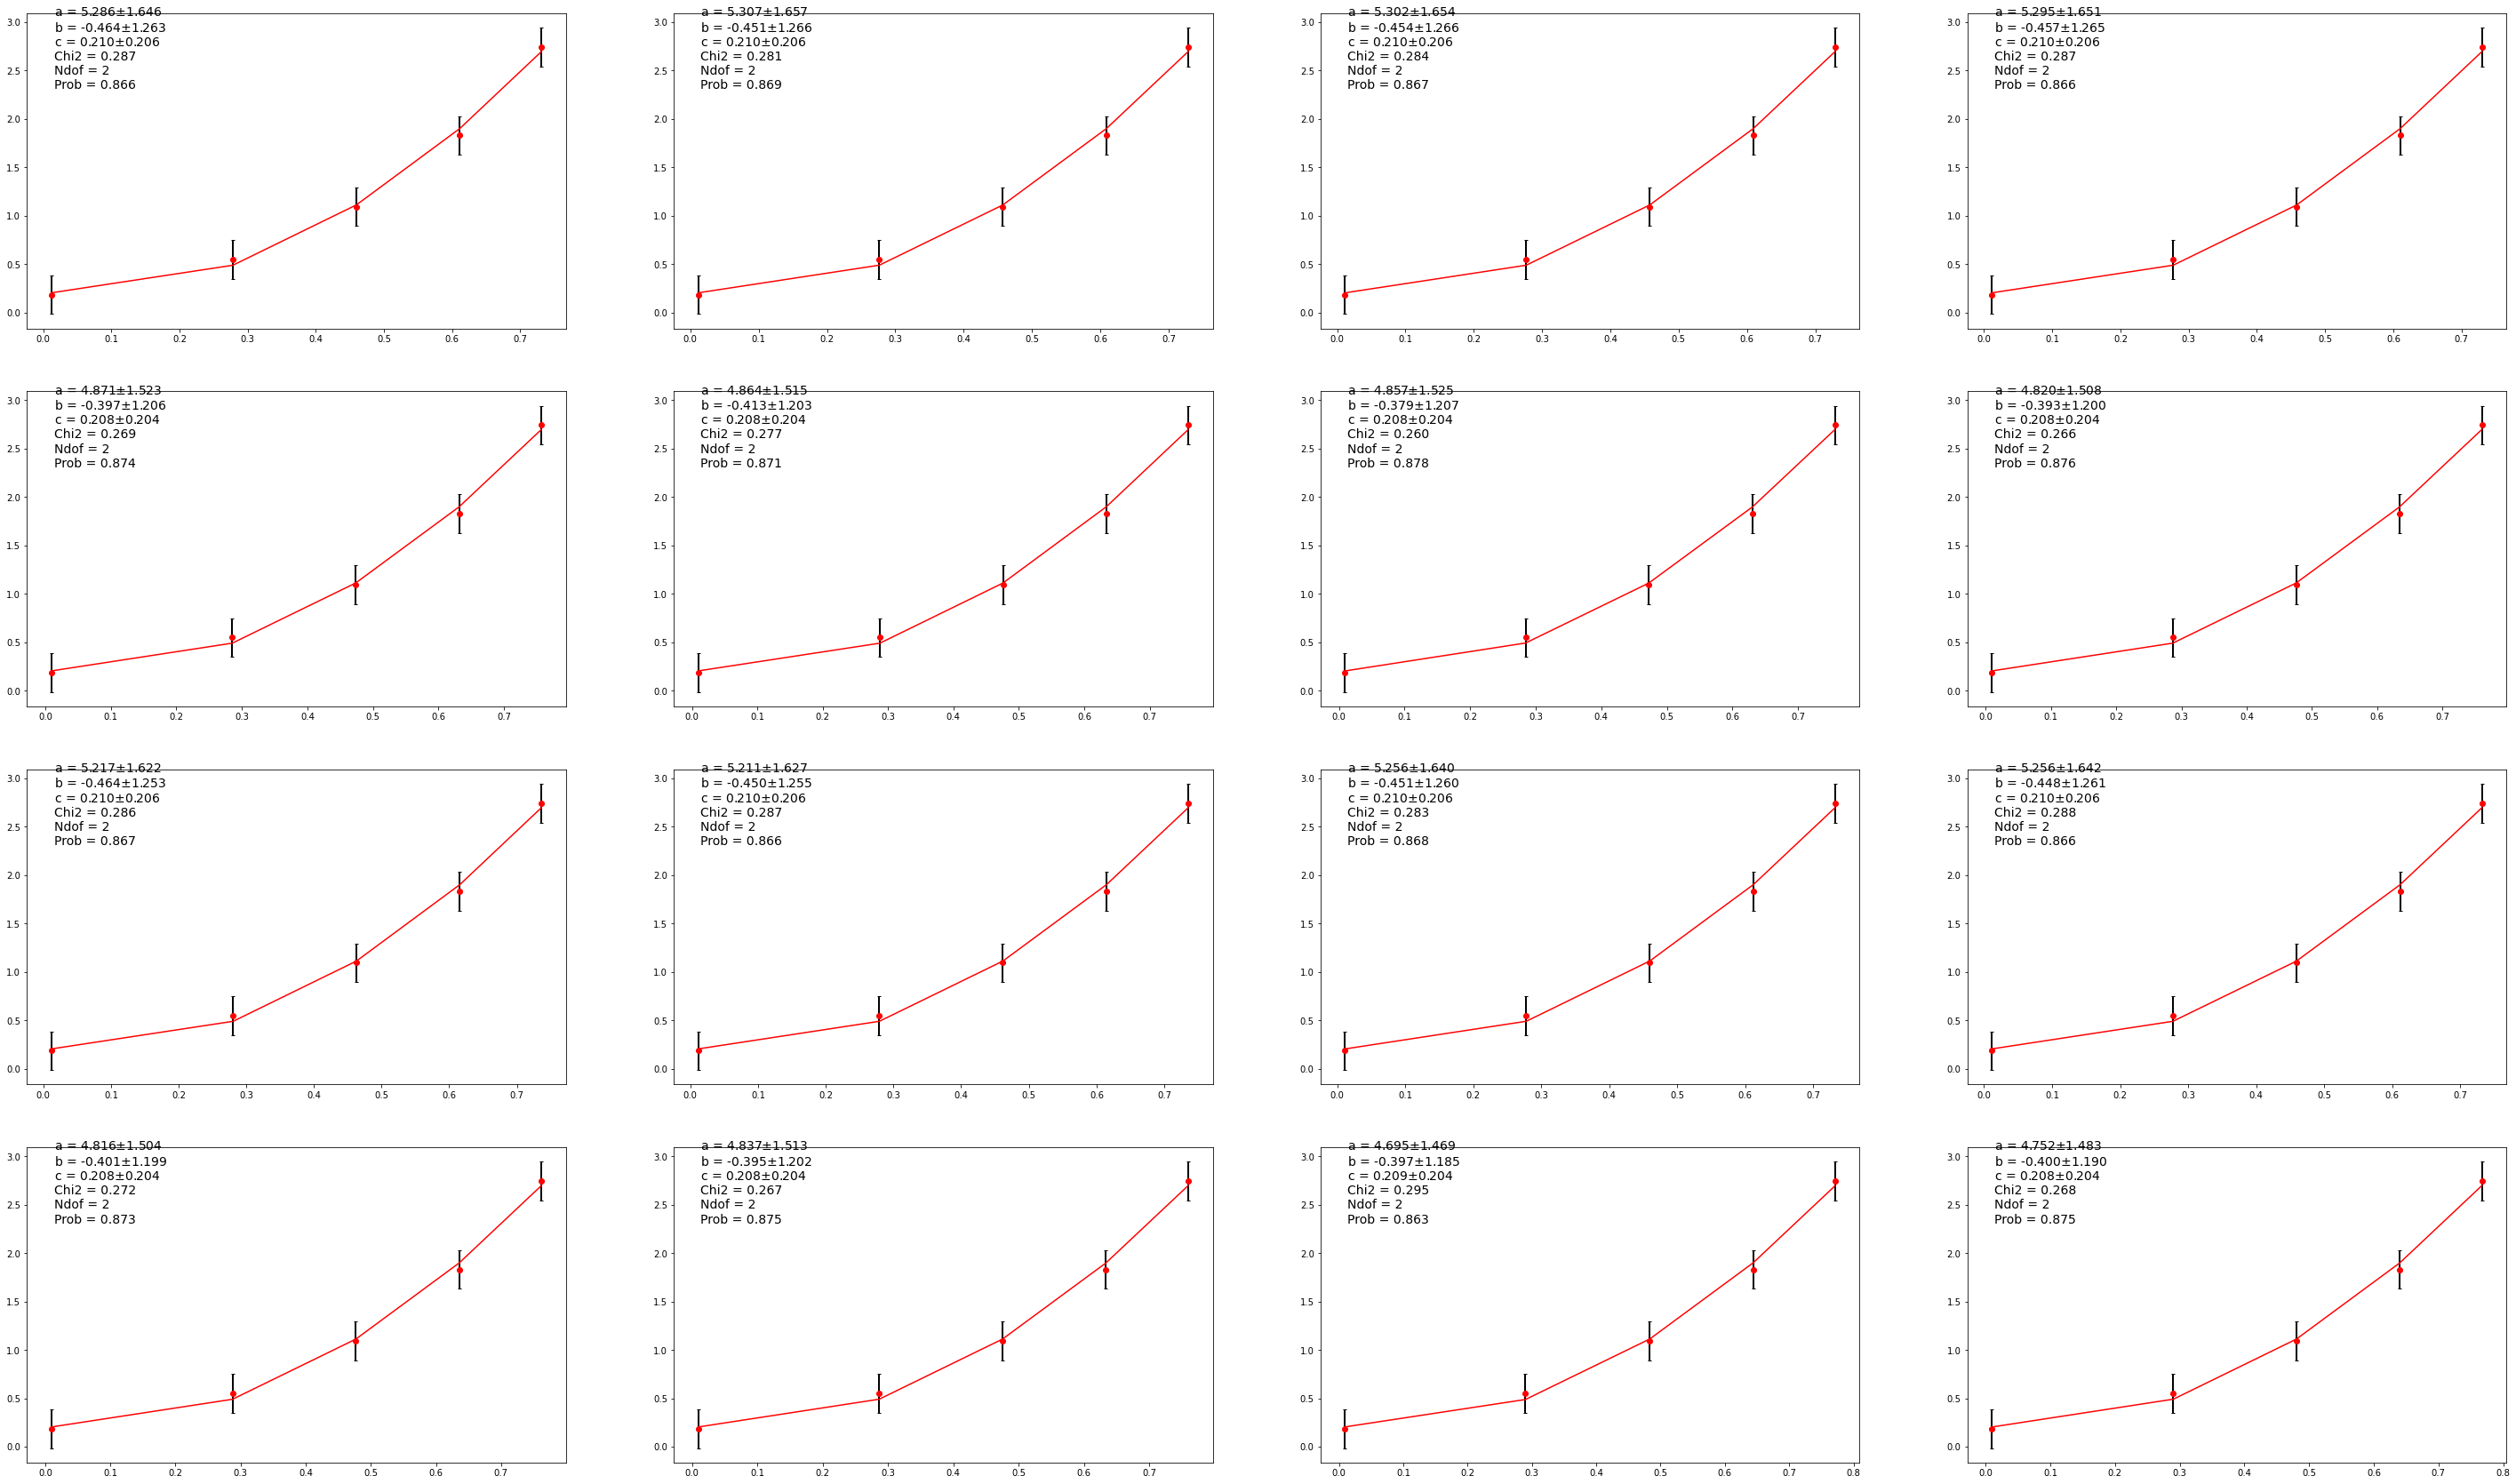

In [8]:
fig, axs = plt.subplots(4,4,figsize=(50,30))
axs = axs.flatten()

final_a = np.zeros(16)
for i, data in enumerate(data_points):
    ax = axs[i]
    data_peaks = data[data[:,1] > 4.5]

    time_start = data_peaks[(np.abs(np.roll(data_peaks,1,axis=0)-data_peaks)[:,0]) > 0.01][:,0]
    time_stop =data_peaks[(np.abs(np.roll(data_peaks,-1,axis=0)-data_peaks)[:,0]) > 0.01][:,0]

    t  =  (time_start + (time_stop - time_start)/2 - time_start[0])[:5]
    
    bold_2 = 0.0125

    a, b, c = 9.82, 0, 0
    sigmay = 0.2

    x = np.array(t)

    y = np.cumsum(samlet_afstand)
    sy = sigmay * np.ones_like(x)

    def fit_func(x, a, b, c): 
        return a*x**2 + b*x + c

    chi2 = LeastSquares(x,y,sy,fit_func)

    def chi2_func( a, b, c):
        return np.sum(((y - fit_func(x, a, b, c)) / sy)**2)

    mfit = Minuit(chi2_func,a=a,b=b, c=c)

    mfit.migrad()

    a_fit = mfit.values['a']
    b_fit = mfit.values['b']
    c_fit = mfit.values['c']
    sigma_c_fit = mfit.errors['c']
    sigma_a_fit = mfit.errors['a']
    sigma_b_fit = mfit.errors['b']
    final_a[i] = a_fit
    Nvar = 3                   
    Ndof_fit = len(t) - Nvar

    Chi2_fit = mfit.fval                            
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)
    
    print(f"fit: a={a_fit:6.3f}+-{sigma_a_fit:5.3f}  b={b_fit:5.3f}+-{sigma_b_fit:5.3f}  c={c_fit:5.3f}+-{sigma_c_fit:5.3f}  p={Prob_fit:6.4f}")
    ax.errorbar(x, y, sy, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
    ax.plot(x, fit_func(x, *mfit.values[:]), '-r')      

    fit_info = [f'a = {a_fit:5.3f}' + r'$\pm$' +  f"{sigma_a_fit:5.3f}",
                f'b = {b_fit:5.3f}' + r'$\pm$' + f"{sigma_b_fit:5.3f}",
                f'c = {c_fit:5.3f}' + r'$\pm$' + f"{sigma_c_fit:5.3f}",
                f'Chi2 = {Chi2_fit:5.3f}',
                f'Ndof = {Ndof_fit:d}',
                f'Prob = {Prob_fit:5.3f}',
    ]

    ax.text(0.05, 0.76, "\n".join(fit_info), fontsize=14, transform = ax.transAxes)



In [9]:
rail_tyk = (3 + 2.9 + 3 + 3) / 400 

#regnet vinkel 
a = (22.2 + 22+ 22.2 + 22.3 - 4*rail_tyk) / 400
c = (93.45 + 93.65 + 93.5 + 93.6) / 400
b = np.sqrt(c**2 - a**2)
print(b)

theta2 = np.arcsin(b / c)
print(theta2*180 / np.pi)

0.9089109088594713
76.30690814368934


In [10]:
a_1 = final_a 
theta = np.deg2rad(90-samlet_vinkel)
g = (a_1 / np.sin(theta)) * (1+(2/5)*(bold_1**2) / (bold_1**2 - d_r_inder**2))
print(g)



[35.95251368 36.09598824 36.06168268 36.01534484 33.12898004 33.08105874
 33.03426852 32.78733021 35.48297118 35.44284395 35.74831177 35.74797635
 32.75919379 32.89997241 31.93390158 32.32303415]
